# Import

In [28]:
import os
import numpy as np
import pandas as pd
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# Catboost model
from catboost import CatBoostClassifier, Pool

# Optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 데이터 불러오기

In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110
pd.set_option('display.max_columns', None)
# Load data
train_df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
sensitivity_analysis_results_df = pd.read_csv(os.path.join(ROOT_DIR, "sensitivity_analysis_results.csv"))

In [3]:
train_df

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Z Unit Time_Dam,CURE END POSITION Z Judge Value_Dam,CURE END POSITION Θ Collect Result_Dam,CURE END POSITION Θ Unit Time_Dam,CURE END POSITION Θ Judge Value_Dam,CURE SPEED Collect Result_Dam,CURE SPEED Unit Time_Dam,CURE SPEED Judge Value_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION X Unit Time_Dam,CURE STANDBY POSITION X Judge Value_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Z Unit Time_Dam,CURE STANDBY POSITION Z Judge Value_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE STANDBY POSITION Θ Unit Time_Dam,CURE STANDBY POSITION Θ Judge Value_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION X Unit Time_Dam,CURE START POSITION X Judge Value_Dam,CURE START POSITION Z Collect Result_Dam,CURE START POSITION Z Unit Time_Dam,CURE START POSITION Z Judge Value_Dam,CURE START POSITION Θ Collect Result_Dam,CURE START POSITION Θ Unit Time_Dam,CURE START POSITION Θ Judge Value_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED SPEED OF RESIN Unit Time_Dam,DISCHARGED SPEED OF RESIN Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage2) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage3) Judge Value_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage1) Unit Time_Dam,Dispense Volume(Stage1) Judge Value_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage2) Unit Time_Dam,Dispense Volume(Stage2) Judge Value_Dam,Dispense Volume(Stage3) Collect Result_Dam,Dispense Volume(Stage3) Unit Time_Dam,Dispense Volume(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position X Unit Time_Dam,HEAD Standby Position X Judge Value_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Y Unit Time_Dam,HEAD Standby Position Y Judge Value_Dam,HEAD Standby Position Z Collect Result_Dam,HEAD Standby Position Z Unit Time_Dam,HEAD Standby Position Z Judge Value_Dam,Head

# 데이터 확인

In [5]:
train_df['target'].value_counts()
# 'normal' = 38156개 'Abnormal' = 2350
# 16:1 의 비로 클래스 불균형

target
Normal      38156
AbNormal     2350
Name: count, dtype: int64

In [6]:
# NaN값이 있는 열 확인
train_df.isnull().sum()

Wip Line_Dam                         0
Process Desc._Dam                    0
Equipment_Dam                        0
Model.Suffix_Dam                     0
Workorder_Dam                        0
                                 ...  
Receip No Judge Value_Fill2      40506
WorkMode Collect Result_Fill2        0
WorkMode Unit Time_Fill2         40506
WorkMode Judge Value_Fill2       40506
target                               0
Length: 464, dtype: int64

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'AJX75334505'),
  Text(1, 0, 'AJX75334501'),
  Text(2, 0, 'AJX75334502'),
  Text(3, 0, 'AJX75334507'),
  Text(4, 0, 'AJX75334506'),
  Text(5, 0, 'AJX75334508'),
  Text(6, 0, 'AJX75334503')])

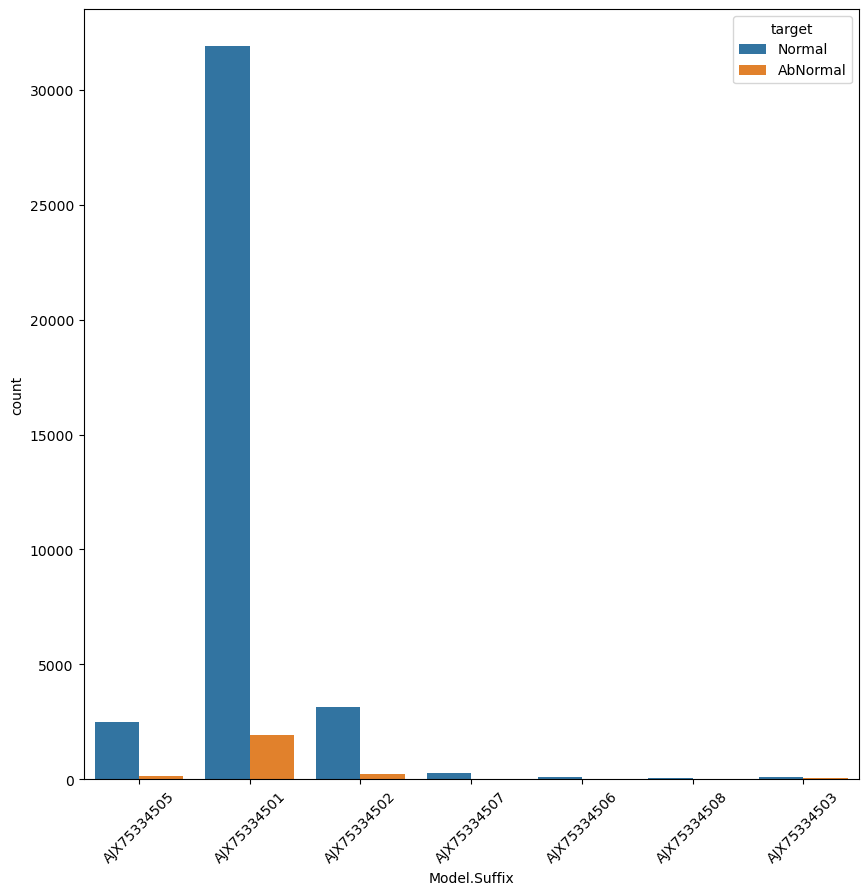

In [7]:
# Model.Suffix를 기준으로 클래스 확인하기
plt.figure(figsize = (10, 10))
sns.countplot(x = 'Model.Suffix_AutoClave', hue = 'target', data = train_df)
plt.xlabel('Model.Suffix', fontsize = 10)
plt.xticks(rotation=45)

# 데이터 전처리

In [8]:
# 불필요한 칼럼 제거
def drop_columns_if_exist(df, columns_to_drop):
    for column in columns_to_drop:
        if column in df.columns:
            df = df.drop(column, axis=1)
            print(f"Column '{column}' dropped.")
        else:
            print(f"Column '{column}' does not exist.")
    return df

In [9]:
train_df = drop_columns_if_exist(train_df, {
    'Wip Line_Dam', 'Wip Line_AutoClave', 'Wip Line_Fill1', 'Wip Line_Fill2',
    'Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2',
    'Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2',
    'Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'
})

test_df = drop_columns_if_exist(test_df, {
    'Wip Line_Dam','Wip Line_AutoClave', 'Wip Line_Fill1', 'Wip Line_Fill2',
    'Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2',
    'Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2',
    'Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'
})

Column 'Insp. Seq No._Dam' dropped.
Column 'Wip Line_Dam' dropped.
Column 'Process Desc._Dam' dropped.
Column 'Process Desc._AutoClave' dropped.
Column 'Wip Line_Fill1' dropped.
Column 'Insp Judge Code_AutoClave' dropped.
Column 'Wip Line_AutoClave' dropped.
Column 'Insp Judge Code_Dam' dropped.
Column 'Insp. Seq No._Fill1' dropped.
Column 'Insp. Seq No._Fill2' dropped.
Column 'Wip Line_Fill2' dropped.
Column 'Process Desc._Fill1' dropped.
Column 'Process Desc._Fill2' dropped.
Column 'Insp Judge Code_Fill2' dropped.
Column 'Insp. Seq No._AutoClave' dropped.
Column 'Insp Judge Code_Fill1' dropped.
Column 'Insp. Seq No._Dam' dropped.
Column 'Wip Line_Dam' dropped.
Column 'Process Desc._Dam' dropped.
Column 'Process Desc._AutoClave' dropped.
Column 'Wip Line_Fill1' dropped.
Column 'Insp Judge Code_AutoClave' dropped.
Column 'Wip Line_AutoClave' dropped.
Column 'Insp Judge Code_Dam' dropped.
Column 'Insp. Seq No._Fill1' dropped.
Column 'Insp. Seq No._Fill2' dropped.
Column 'Wip Line_Fill2'

In [10]:
# 모든 행이 NaN값인 열 제거
train_df = train_df.dropna(how='all', axis=1)
test_df = test_df.dropna(how='all', axis=1)

In [11]:
# Set ID 삭제
test_df = test_df.drop(columns=['Set ID'])

In [12]:
# 기존 데이터프레임에서 'Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2' 칼럼 추출
equipment_columns = ['Equipment_Dam','Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2']
df_equipment = train_df[equipment_columns]

# 새로운 데이터프레임 생성
df_new = pd.DataFrame(df_equipment)

# 결과 출력
df_new

,Equipment_Dam,Equipment_AutoClave,Equipment_Fill1,Equipment_Fill2
0,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
1,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
2,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2
3,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2
4,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
...,...,...,...,...
40501,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
40502,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2
40503,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
40504,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2


In [13]:
# 주어진 패턴 정의
pattern1 = ['Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #1']
pattern2 = ['Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #2']

# 주어진 패턴과 일치하는 행 찾기
df_new['Matches_Pattern'] = df_new.apply(lambda row: (row.values.tolist() == pattern1) or (row.values.tolist() == pattern2), axis=1)

# 주어진 패턴과 일치하지 않는 행 출력
non_matching_rows = df_new[~df_new['Matches_Pattern']]

print("주어진 패턴과 일치하지 않는 행:")
print(non_matching_rows)

주어진 패턴과 일치하지 않는 행:
          Equipment_Dam Equipment_AutoClave     Equipment_Fill1  \
3364   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #2   
4787   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
5102   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
5561   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
5922   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
6560   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #2   
6563   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #2   
9724   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
10007  Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
13028  Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
14452  Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
15612  Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
17078  Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
17503  Dam dispenser #1      Auto Clave Out

In [15]:
import pandas as pd
import itertools

# equipment 칼럼 조합 레이블링
# 가능한 조합 생성
equipment_dam = ['Dam dispenser #1', 'Dam dispenser #2']
equipment_autoclave = ['Auto Clave Out']
equipment_fill1 = ['Fill1 dispenser #1', 'Fill1 dispenser #2']
equipment_fill2 = ['Fill2 dispenser #1', 'Fill2 dispenser #2']

combinations = list(itertools.product(equipment_dam, equipment_autoclave, equipment_fill1, equipment_fill2))

# 조합에 고유 레이블 할당
combination_labels = {comb: idx for idx, comb in enumerate(combinations)}

# 레이블링 함수
def label_row(row):
    comb = (row['Equipment_Dam'], row['Equipment_AutoClave'], row['Equipment_Fill1'], row['Equipment_Fill2'])
    return combination_labels.get(comb, -1)  # 조합이 없을 경우 -1 반환

# 데이터프레임에 레이블 컬럼 추가
train_df['Equipment'] = train_df.apply(label_row, axis=1)
test_df['Equipment'] = test_df.apply(label_row, axis=1)

# Equipment_Label을 맨 앞에 추가
train_df.insert(0, 'Equipment', train_df.pop('Equipment'))
test_df.insert(0, 'Equipment', test_df.pop('Equipment'))

# 조합 레이블 출력 함수
def print_combination_labels(combination_labels):
    for comb, label in combination_labels.items():
        print(f"Combination: {comb} -> Label: {label}")

# 결과 출력
print_combination_labels(combination_labels)
print(train_df['Equipment'].value_counts())


Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #1') -> Label: 0
Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #2') -> Label: 1
Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #1') -> Label: 2
Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #2') -> Label: 3
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #1') -> Label: 4
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #2') -> Label: 5
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #1') -> Label: 6
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #2') -> Label: 7
Equipment
0    25011
7    15461
3       13
4       10
1        6
6        5
Name: count, dtype: int64


In [16]:
# 필요 없는 칼럼 삭제하고 'Model.Suffix_Dam' 칼럼 이름 변경하고
train_df = train_df.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
train_df = train_df.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

test_df = test_df.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_df = test_df.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

# workorder도 다음과 같이 삭제 및 변경

train_df = train_df.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
train_df = train_df.rename(columns={'Workorder_Dam': 'Workorder'})

test_df = test_df.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_df = test_df.rename(columns={'Workorder_Dam': 'Workorder'})

# Equipment 삭제
train_df = train_df.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
test_df = test_df.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])

In [17]:
# 이름 이상한부분 변경
train_df = train_df.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_df = test_df.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

In [18]:
# 모든 행의 값이 같은 열 삭제
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]
test_df = test_df.loc[:, (test_df != test_df.iloc[0]).any()]


In [20]:
# case 1 안 합치고
# except_columns = {'Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2',
#                 'Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
#                 'Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2',
#                 'target'}

# case 2 합치고
except_columns = {'Equipment', 'Model.Suffix', 'Workorder', 'target'}
def find_string_value(df):
    string_columns = []

    for col in df.columns:
        if df[col].apply(lambda x : isinstance(x, str)).any() and col not in except_columns:
            string_columns.append(col)
            print(f"Column '{col}' contains string values")

    for col in string_columns:
        print(df[col].value_counts())

    return string_columns

# "OK" -> 1, "NG" -> 0으로 인코딩
def incording_string_value(df, string_columns):
    for col in string_columns:
        df[col] = df[col].apply(lambda x: 1 if x == "OK" else 0 if x == "NG" else x)
        df[col] = df[col].astype(float)

train_df_string_columns = find_string_value(train_df)
incording_string_value(train_df, train_df_string_columns)

test_df_string_columns = find_string_value(test_df)
incording_string_value(test_df, test_df_string_columns)

Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam' contains string values
Column 'Chamber Temp. Judge Value_AutoClave' contains string values
Column 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave' contains string values
Column 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2' contains string values
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
OK       11293
549       7271
162.4     3580
550       2398
550.3     1909
549.5     1263
548.5       26
Name: count, dtype: int64
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge 

In [21]:
# NaN값 모두 0으로 보간
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# 레이블 인코딩

In [22]:
from sklearn.preprocessing import LabelEncoder

# 'Abnormal' = 0, 'normal' = 1
# case 2 합치고
qual_col = ['Equipment', 'Model.Suffix', 'Workorder', 'target',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
            'Chamber Temp. Judge Value_AutoClave',
            'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
            'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
            ]
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_df[i])
    train_df[i] = le.transform(train_df[i])

    if not i == 'target':
        for label in np.unique(test_df[i]):
            if label not in le.classes_ :
                le.classes_ = np.append(le.classes_, label)
        test_df[i] = le.transform(test_df[i])


In [23]:
# 1. 각 Equipment 값에 대해 target=0 (AbNormal) 비율을 계산
model_suffix_counts = train_df.groupby(['Equipment'])['target'].value_counts(normalize=True).unstack(fill_value=0)

# 2. AbNormal 비율만 추출
abnormal_ratios = model_suffix_counts[0]  # target=0인 비율

# 3. 가중치 설정
# 여기서는 AbNormal 비율을 그대로 가중치로 사용하지만, 상황에 따라 가중치를 조정할 수 있습니다.
train_df['Weight_Equipment'] = train_df['Equipment'].map(abnormal_ratios)

# 4. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Equipment'] = test_df['Equipment'].map(abnormal_ratios)

# 5. 결과 확인
print(train_df[['Equipment', 'Weight_Equipment']].head())
# 1. 각 Model.Suffix 값에 대해 target=0 (AbNormal) 비율을 계산
model_suffix_counts = train_df.groupby(['Model.Suffix'])['target'].value_counts(normalize=True).unstack(fill_value=0)

# 2. AbNormal 비율만 추출
abnormal_ratios = model_suffix_counts[0]  # target=0인 비율

# 3. 가중치 설정
# 여기서는 AbNormal 비율을 그대로 가중치로 사용하지만, 상황에 따라 가중치를 조정할 수 있습니다.
train_df['Weight_Model.Suffix'] = train_df['Model.Suffix'].map(abnormal_ratios)

# 4. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Model.Suffix'] = test_df['Model.Suffix'].map(abnormal_ratios)

# 5. 결과 확인
print(train_df[['Model.Suffix', 'Weight_Model.Suffix']].head())

# 각 칼럼 값이 모두 동일한지 여부를 판단하여 가중치 행렬 생성
train_df['Weight_Production_Qty'] = train_df.apply(
    lambda row: 1 if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) else 0, axis=1
)

test_df['Weight_Production_Qty'] = test_df.apply(
    lambda row: 1 if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) else 0, axis=1
)

# 결과 확인
print(train_df[['Production Qty Collect Result_Dam', 'Production Qty Collect Result_Fill1', 'Production Qty Collect Result_Fill2', 'Weight_Production_Qty']].head())
print(test_df[['Production Qty Collect Result_Dam', 'Production Qty Collect Result_Fill1', 'Production Qty Collect Result_Fill2', 'Weight_Production_Qty']].head())


# 1. 각 조합별로 target=0 (AbNormal)의 비율을 계산
result = train_df.groupby(['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])['target'].value_counts(normalize=False).unstack(fill_value=0)

# 2. AbNormal (target=0)의 개수 추출
abnormal_counts = result[0]  # target=0인 개수

# 3. 전체 AbNormal 개수 계산
total_abnormal_count = abnormal_counts.sum()

# 4. AbNormal 비율을 전체 AbNormal 개수로 나누어 가중치 설정
weights = abnormal_counts / total_abnormal_count

# 5. train_df에 가중치 열 추가
train_df['Weight_Receip_NO'] = train_df[['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']].apply(
    lambda row: weights.get(tuple(row), 0), axis=1
)
# 6. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Receip_NO'] = test_df[['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']].apply(
    lambda row: weights.get(tuple(row), 0), axis=1
)

# 7. 결과 확인
print(train_df[['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2', 'Weight_Receip_NO']].head())




   Equipment  Weight_Equipment
0          0          0.058614
1          0          0.058614
2          5          0.054977
3          5          0.054977
4          0          0.058614
   Model.Suffix  Weight_Model.Suffix
0             3             0.049336
1             3             0.049336
2             0             0.056712
3             0             0.056712
4             0             0.056712
   Production Qty Collect Result_Dam  Production Qty Collect Result_Fill1  \
0                                  7                                    7   
1                                185                                  185   
2                                 10                                   10   
3                                268                                  268   
4                                121                                  121   

   Production Qty Collect Result_Fill2  Weight_Production_Qty  
0                                    7                      1  
1

# 클래스 가중치

In [ ]:
# 클래스 가중치
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_df['target'])
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = train_df['target'])
class_weights = dict(zip(classes, weights))
class_weights

{0: 8.618297872340426, 1: 0.5307946325610651}

# Modeling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

# 범주형 특징 열을 정의
cat_features = [
    'Equipment',
    'Model.Suffix',
    'Workorder',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
]

scaler = MinMaxScaler(feature_range=(0, 1))
# Select the weight columns
weights = train_df[[
       'Weight_Equipment',
       'Weight_Model.Suffix',
    #    'Weight_MOVEMENT_DISTANCE',
       'Weight_Production_Qty',
       'Weight_Receip_NO',
]]
scaled_weights = scaler.fit_transform(weights)

# train_df['combined_weight'] = (
#     0.15 * weights['Weight_Equipment'] +
#     0.15 * weights['Weight_Model.Suffix'] +
#     0.15 * weights['Weight_Production_Qty'] +
#     0.15 * weights['Weight_Receip_NO']+
#     # 0.4 * weights['Weight_MOVEMENT_DISTANCE']
# )
# Apply log transformation to scaled weights
train_df['combined_weight'] = np.log1p(np.sum(scaled_weights, axis=1))
# # Apply threshold to the combined weight
# threshold_value=2.0
# train_df['combined_weight'] = np.minimum(np.sum(scaled_weights, axis=1), threshold_value)


# Combine multiple weight columns into a single weight vector
# train_df['combined_weight'] = train_df['Weight_Equipment']*0.2 + train_df['Weight_Model.Suffix']*0.2 + train_df['Weight_Receip_NO']*0.3+ train_df['Weight_Production_Qty']*0.3

# CatBoostClassifier 설정
cbc = CatBoostClassifier(
    iterations=5000,        # 초기 10000에서 5000으로 감소, 더 빠른 학습과 검증을 위해
    learning_rate=0.005,    # 학습률을 더 낮추어 안정적인 학습
    depth=8,                # 깊이를 약간 증가시켜 더 복잡한 패턴 학습 가능
    l2_leaf_reg=10,        # 정규화 강도 증가, 과적합 방지
    verbose=100,
    grow_policy='Depthwise',  # 트리 성장 정책
    score_function='Cosine',
    cat_features=cat_features,
    class_weights=class_weights,
    task_type='CPU'
)

# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Data
x = train_df.drop(columns=[
        'target',
        'Weight_Equipment',
        'Weight_Model.Suffix',
        'Weight_Production_Qty',
        'Weight_Receip_NO',
        'combined_weight'
    ])

y = train_df['target']
sample_weight = train_df['combined_weight']

cbc_result = 0
feature_importance = 0
all_metrics = []

for train_idx, valid_idx in skf.split(x, y):
    x_train = x.iloc[train_idx]
    x_valid = x.iloc[valid_idx]
    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]
    sample_weight_train = sample_weight.iloc[train_idx]

    cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), sample_weight=sample_weight_train, early_stopping_rounds=100)
    cbc_result += cbc.predict_proba(test_df) / 10
    feature_importance += cbc.feature_importances_ / 10

    # 검증 데이터 예측
    y_pred = cbc.predict(x_valid)
    y_pred_proba = cbc.predict_proba(x_valid)[:, 1]

    # 다양한 지표 계산
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, pos_label=0)
    recall = recall_score(y_valid, y_pred, pos_label=0)
    f1 = f1_score(y_valid, y_pred, pos_label=0)

    # 혼동 행렬
    conf_matrix = confusion_matrix(y_valid, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }
    all_metrics.append(metrics)

# 결과 출력
for i, metrics in enumerate(all_metrics):
    print(f"Fold {i+1} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    print("\n")

# 최종 평균 지표 계산 및 출력
average_metrics = {
    'accuracy': np.mean([metrics['accuracy'] for metrics in all_metrics]),
    'precision': np.mean([metrics['precision'] for metrics in all_metrics]),
    'recall': np.mean([metrics['recall'] for metrics in all_metrics]),
    'f1_score': np.mean([metrics['f1_score'] for metrics in all_metrics]),
}

print("Average Metrics:")
print(f"Average Accuracy: {average_metrics['accuracy']:.4f}")
print(f"Average Precision: {average_metrics['precision']:.4f}")
print(f"Average Recall: {average_metrics['recall']:.4f}")
print(f"Average F1 Score: {average_metrics['f1_score']:.4f}")

# 중요 특징 출력 (소수점 4자리로 포맷)
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# 소수점 4자리로 출력
pd.options.display.float_format = '{:.4f}'.format

print('Feature Importances:')
print(feature_importance_df)

0:	learn: 0.6922235	test: 0.6921842	best: 0.6921842 (0)	total: 89.5ms	remaining: 2m 58s
100:	learn: 0.6497056	test: 0.6533548	best: 0.6533548 (100)	total: 717ms	remaining: 13.5s
200:	learn: 0.6323762	test: 0.6412936	best: 0.6412936 (200)	total: 1.29s	remaining: 11.6s
300:	learn: 0.6209674	test: 0.6366280	best: 0.6366280 (300)	total: 1.88s	remaining: 10.6s
400:	learn: 0.6115535	test: 0.6353376	best: 0.6352911 (393)	total: 2.47s	remaining: 9.84s
500:	learn: 0.6035866	test: 0.6343491	best: 0.6341775 (489)	total: 3.05s	remaining: 9.14s
600:	learn: 0.5960664	test: 0.6330358	best: 0.6328869 (589)	total: 3.64s	remaining: 8.48s
700:	learn: 0.5890894	test: 0.6319835	best: 0.6318299 (696)	total: 4.23s	remaining: 7.84s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6318299359
bestIteration = 696

Shrink model to first 697 iterations.
0:	learn: 0.6924500	test: 0.6923472	best: 0.6923472 (0)	total: 7.11ms	remaining: 14.2s
100:	learn: 0.6504687	test: 0.6435708	best: 0.6435708 (1

In [ ]:
result = pd.DataFrame(cbc_result)

result['target'] = result.apply(lambda row: 'AbNormal' if row[0] > row[1] else 'Normal', axis=1)

# 결과 저장
submission = pd.read_csv('submission.csv')
submission['target'] = result['target']
submission.to_csv("submission.csv", index=False)

print("Prediction and submission file saved.")


Prediction and submission file saved.


In [ ]:
df_AbNormal = result[result['target'] == 'AbNormal']
df_AbNormal

,0,1,target
0,0.577311,0.422689,AbNormal
2,0.592603,0.407397,AbNormal
5,0.619092,0.380908,AbNormal
6,0.664472,0.335528,AbNormal
7,0.645678,0.354322,AbNormal
...,...,...,...
17341,0.619071,0.380929,AbNormal
17346,0.690084,0.309916,AbNormal
17347,0.587586,0.412414,AbNormal
17353,0.671106,0.328894,AbNormal


In [ ]:
submission['target'].value_counts()

target
Normal      11959
AbNormal     5402
Name: count, dtype: int64